In [4]:
import torch
import torchvision
import torchvision.transforms as transforms


In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),   
    transforms.RandomHorizontalFlip(),     
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # mean
                         (0.2023, 0.1994, 0.2010))  # std
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./pj2data', train=True,
                                        download=False, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./pj2data', train=False,
                                       download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

* initialization

In [6]:
import torch.nn.init as init
import torch.nn as nn
def kaiming_init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.zeros_(m.bias)

### 简单cnn + relu

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.apply(kaiming_init_weights)
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 62006


In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [3]:
import os
import json
import torch

def train(net, trainloader, testloader, criterion, optimizer, scheduler,root='./results', num_epochs=20, device='cuda'):
    os.makedirs(root, exist_ok=True)

    step_losses = []
    epoch_losses = []
    test_accuracies = []

    best_acc = 0.0
    best_epoch = -1
    save_path = os.path.join(root, 'best_model.pth')

    net.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0
        net.train()

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_item = loss.item()
            step_losses.append(loss_item)
            running_loss += loss_item

            if i % 2000 == 1999:
                print(f'[Epoch {epoch + 1}, Step {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        
        epoch_loss = running_loss / len(trainloader)
        epoch_losses.append(epoch_loss)
        print(f'→ Epoch {epoch+1} average loss: {epoch_loss:.4f}')

        # ==== Evaluate ====
        net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        test_accuracies.append(acc)
        print(f'→ Test accuracy after epoch {epoch+1}: {acc:.2f}%')

        # ==== Save best ====
        if acc > best_acc:
            best_acc = acc
            best_epoch = epoch + 1
            torch.save(net.state_dict(), save_path)
            print(f'New best model saved at epoch {best_epoch} with accuracy {best_acc:.2f}%')
        if scheduler:
            scheduler.step()

    print('Training complete.')
    print(f'🏁 Best test accuracy: {best_acc:.2f}% at epoch {best_epoch}')

    # ==== Save logs ====
    with open(os.path.join(root, "step_losses.json"), "w") as f:
        json.dump(step_losses, f)

    with open(os.path.join(root, "epoch_losses.json"), "w") as f:
        json.dump(epoch_losses, f)

    with open(os.path.join(root, "test_accuracies.json"), "w") as f:
        json.dump(test_accuracies, f)

In [ ]:
train(net, trainloader, testloader, criterion, optimizer,None, './results_2', 200, 'cuda')

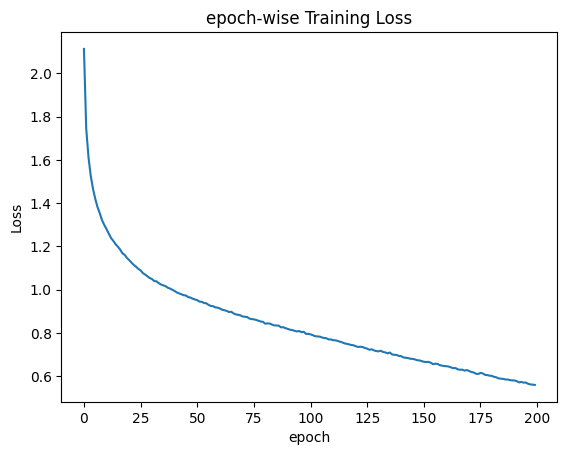

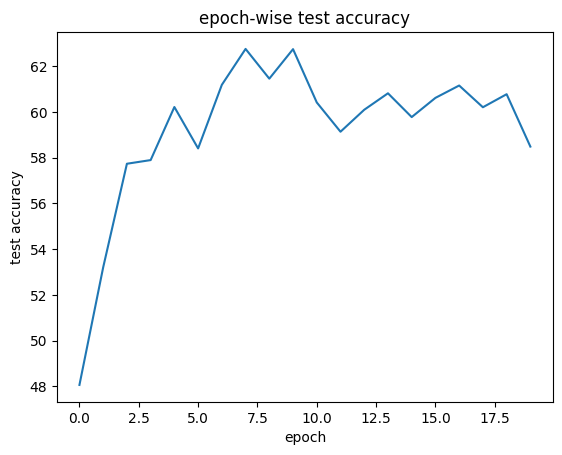

In [2]:
import matplotlib.pyplot as plt
import json

with open("/home/csr/pj2/results_2/epoch_losses.json") as f:
    epoch_losses = json.load(f)

plt.plot(epoch_losses)
plt.title("epoch-wise Training Loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()




with open("test_accuracies.json") as f:
    test_acc = json.load(f)

plt.plot(test_acc)
plt.title("epoch-wise test accuracy")
plt.xlabel("epoch")
plt.ylabel("test accuracy")
plt.show()



## test

In [ ]:
save_path = 'results_2/best_model.pth'
net = Net()


Accuracy of the network on the 10000 test images: 64 %


In [11]:
def test(save_path,net):
    PATH=save_path
    
    net.load_state_dict(torch.load(PATH, weights_only=True))
    correct = 0
    total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    

### Residual Connection + BN 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class DeeperResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

       
        self.layer1 = self._make_layer(16, 32, stride=2)
        self.layer2 = self._make_layer(32, 64, stride=2)
        self.layer3 = self._make_layer(64, 128, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 10)

    def _make_layer(self, in_channels, out_channels, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride, downsample),
            ResidualBlock(out_channels, out_channels)
        )

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        x = self.layer1(x)   # 16x32x32 -> 32x16x16
        x = self.layer2(x)   # 32x16x16 -> 64x8x8
        x = self.layer3(x)   # 64x8x8 -> 128x4x4
        x = self.avgpool(x)  # -> 128x1x1
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


net = DeeperResNet()
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")
net.apply(kaiming_init_weights)

Total trainable parameters: 692122


DeeperResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

In [74]:
from torch.optim import AdamW

optimizer = AdamW(net.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

train(net,trainloader,testloader,criterion,optimizer,scheduler,'./results_3',100,'cuda')

→ Epoch 1 average loss: 1.5347
→ Test accuracy after epoch 1: 56.26%
New best model saved at epoch 1 with accuracy 56.26%
→ Epoch 2 average loss: 1.0371
→ Test accuracy after epoch 2: 62.53%
New best model saved at epoch 2 with accuracy 62.53%
→ Epoch 3 average loss: 0.8248
→ Test accuracy after epoch 3: 66.58%
New best model saved at epoch 3 with accuracy 66.58%
→ Epoch 4 average loss: 0.6679
→ Test accuracy after epoch 4: 67.74%
New best model saved at epoch 4 with accuracy 67.74%
→ Epoch 5 average loss: 0.5350
→ Test accuracy after epoch 5: 71.24%
New best model saved at epoch 5 with accuracy 71.24%
→ Epoch 6 average loss: 0.4341
→ Test accuracy after epoch 6: 71.29%
New best model saved at epoch 6 with accuracy 71.29%
→ Epoch 7 average loss: 0.3364
→ Test accuracy after epoch 7: 69.75%
→ Epoch 8 average loss: 0.2659
→ Test accuracy after epoch 8: 64.10%
→ Epoch 9 average loss: 0.1983
→ Test accuracy after epoch 9: 72.66%
New best model saved at epoch 9 with accuracy 72.66%
→ Epoch 

Accuracy of the network on the 10000 test images: 76 %


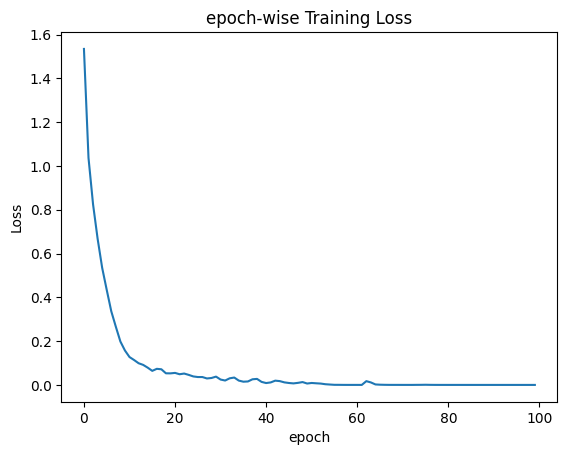

In [77]:
save_path = 'results_3/best_model.pth'
net = DeeperResNet()
def test(save_path,net):
    PATH=save_path
    
    net.load_state_dict(torch.load(PATH, weights_only=True))
    correct = 0
    total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
test(save_path,net)
with open("/home/csr/pj2/results_3/epoch_losses.json") as f:
    epoch_losses = json.load(f)

plt.plot(epoch_losses)
plt.title("epoch-wise Training Loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()


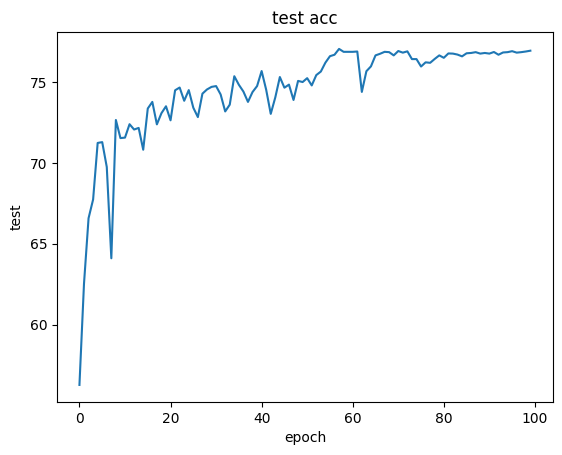

In [30]:
with open("/home/csr/pj2/results_3/test_accuracies.json") as f:
    test_acc = json.load(f)

plt.plot(test_acc)
plt.title("test acc")
plt.xlabel("epoch")
plt.ylabel("test")
plt.show()


## deeper

In [9]:
class DeeperResNet(nn.Module):
    def __init__(self, blocks_per_layer=[3, 3, 3]):
        super().__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(16, 32, stride=2, num_blocks=blocks_per_layer[0])
        self.layer2 = self._make_layer(32, 64, stride=2, num_blocks=blocks_per_layer[1])
        self.layer3 = self._make_layer(64, 128, stride=2, num_blocks=blocks_per_layer[2])

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 10)

    def _make_layer(self, in_channels, out_channels, stride, num_blocks):
        downsample = None
        layers = []

        # 第一个block可能会下采样且改变通道
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))

        # 后面block都保持通道数和步长不变
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


net = DeeperResNet(blocks_per_layer=[3,3,3])
net.apply(kaiming_init_weights)
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 1080090


In [22]:
from torch.optim import AdamW

optimizer = AdamW(net.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=180)

train(net,trainloader,testloader,criterion,optimizer,scheduler,'./deeperer',180,'cuda')

→ Epoch 1 average loss: 1.7057
→ Test accuracy after epoch 1: 47.31%
New best model saved at epoch 1 with accuracy 47.31%
→ Epoch 2 average loss: 1.2632
→ Test accuracy after epoch 2: 58.68%
New best model saved at epoch 2 with accuracy 58.68%
→ Epoch 3 average loss: 1.0644
→ Test accuracy after epoch 3: 63.61%
New best model saved at epoch 3 with accuracy 63.61%
→ Epoch 4 average loss: 0.9344
→ Test accuracy after epoch 4: 70.04%
New best model saved at epoch 4 with accuracy 70.04%
→ Epoch 5 average loss: 0.8248
→ Test accuracy after epoch 5: 72.93%
New best model saved at epoch 5 with accuracy 72.93%
→ Epoch 6 average loss: 0.7456
→ Test accuracy after epoch 6: 72.46%
→ Epoch 7 average loss: 0.6855
→ Test accuracy after epoch 7: 74.64%
New best model saved at epoch 7 with accuracy 74.64%
→ Epoch 8 average loss: 0.6391
→ Test accuracy after epoch 8: 75.97%
New best model saved at epoch 8 with accuracy 75.97%
→ Epoch 9 average loss: 0.5935
→ Test accuracy after epoch 9: 75.17%
→ Epoch 

Accuracy of the network on the 10000 test images: 90 %


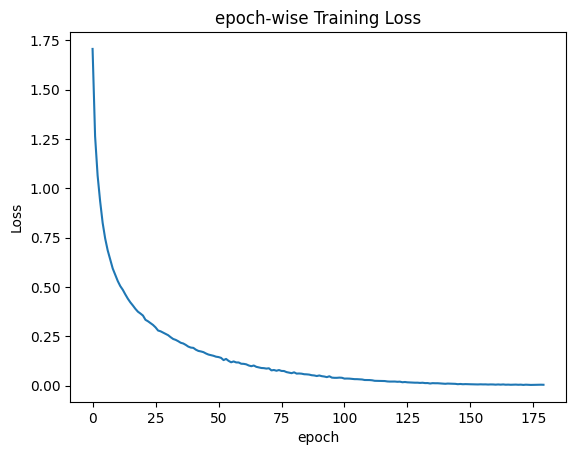

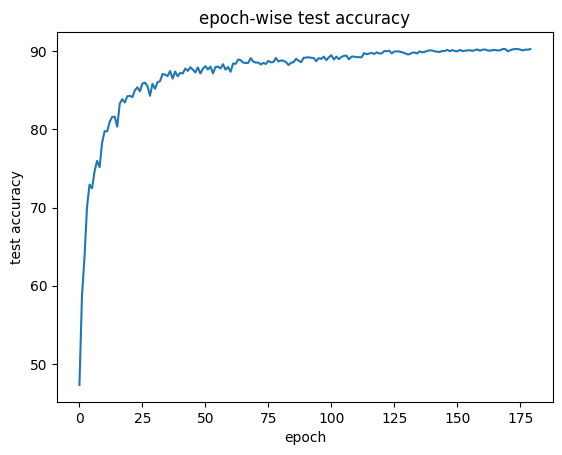

In [13]:
save_path = 'deeperer/best_model.pth'
net = DeeperResNet()
net.eval()
test(save_path,net)
with open("/home/csr/pj2/deeperer/epoch_losses.json") as f:
    epoch_losses = json.load(f)

plt.plot(epoch_losses)
plt.title("epoch-wise Training Loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()

with open("/home/csr/pj2/deeperer/test_accuracies.json") as f:
    epoch_losses = json.load(f)

plt.plot(epoch_losses)
plt.title("epoch-wise test accuracy")
plt.xlabel("epoch")
plt.ylabel("test accuracy")
plt.show()


In [16]:
dataiter = iter(trainloader)
images, labels = next(dataiter)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


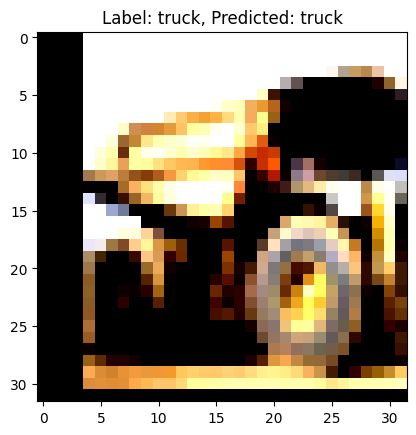

In [24]:
import matplotlib.pyplot as plt
import numpy as np
model=net
# 把 [-1,1] 的图像反标准化
img = images[0] / 2 + 0.5  # 反归一化
label = labels[0].item()  # 提取第一个样本的标签
outputs = model(images) 
_, predicted_class = torch.max(outputs, 1)
pred = predicted_class[0].item() 
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.title(f"Label: {classes[label]}, Predicted: {classes[pred]}")
plt.show()

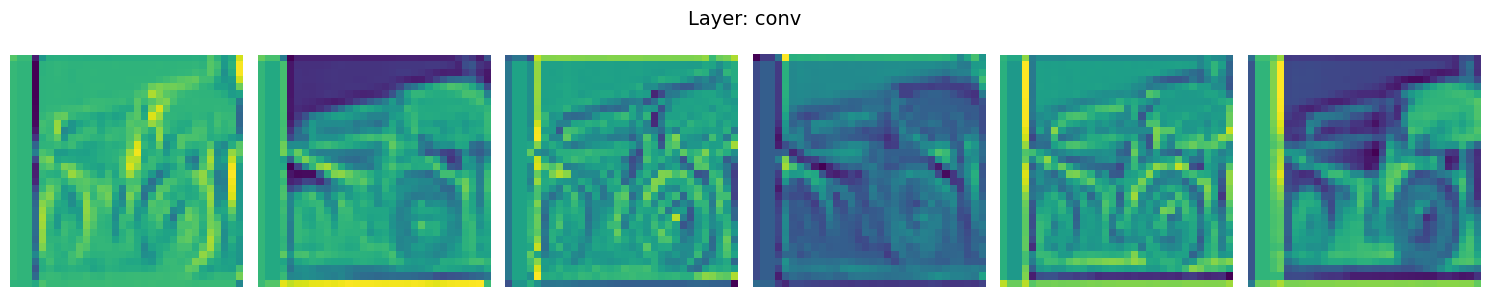

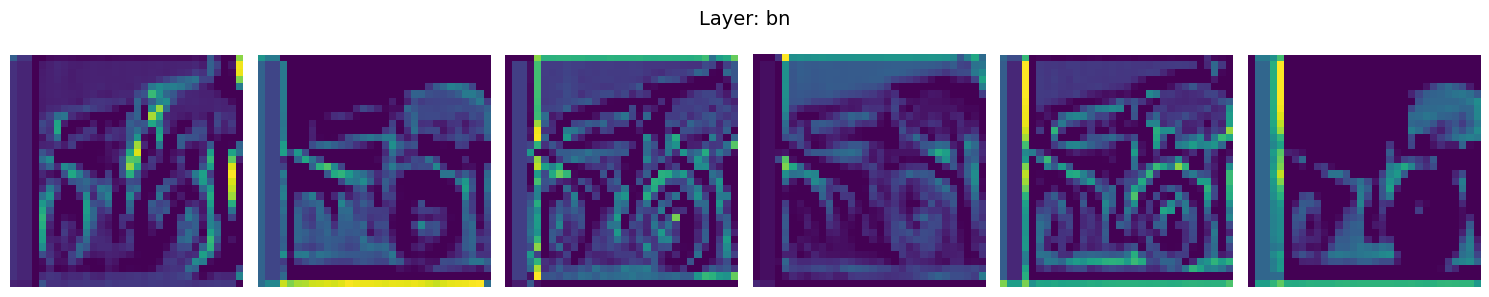

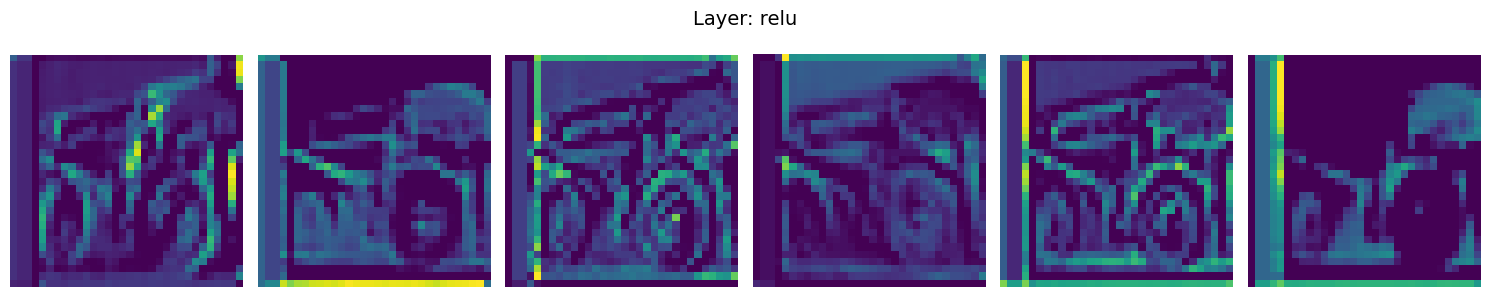

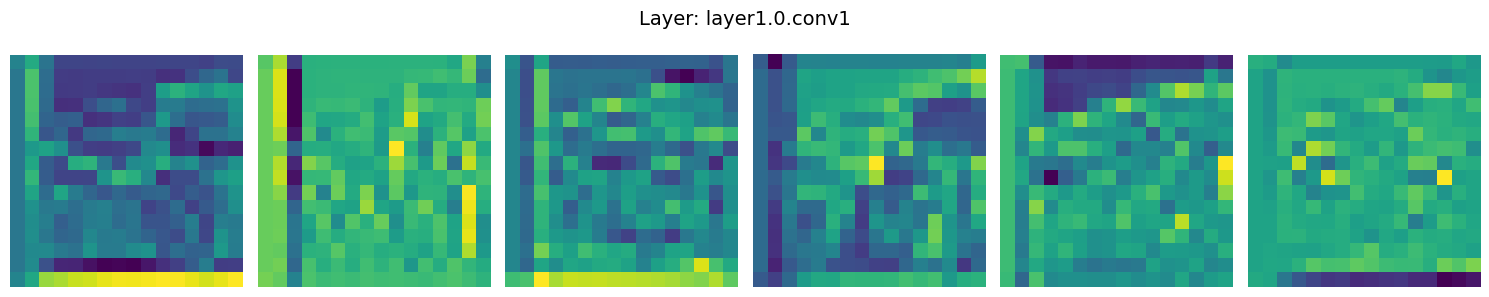

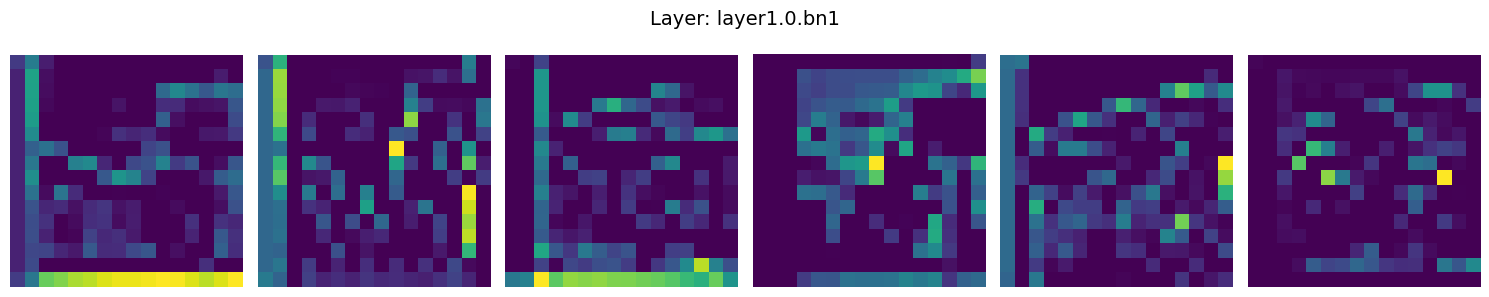

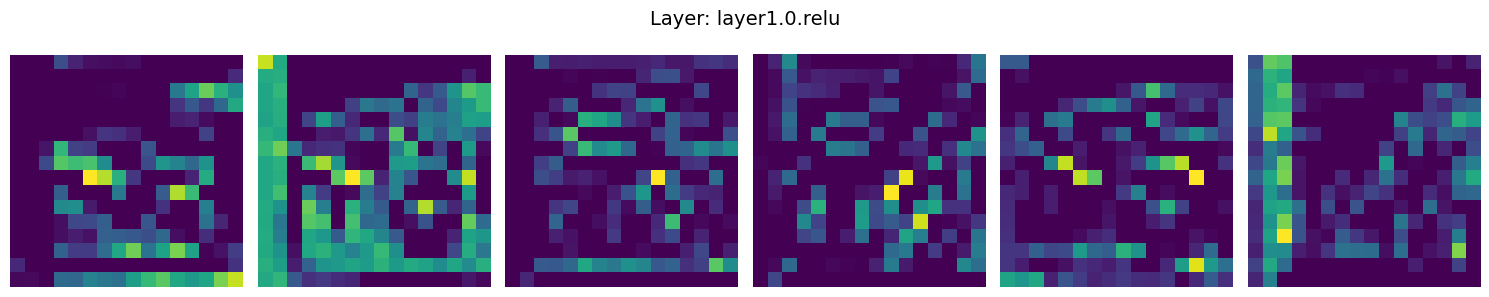

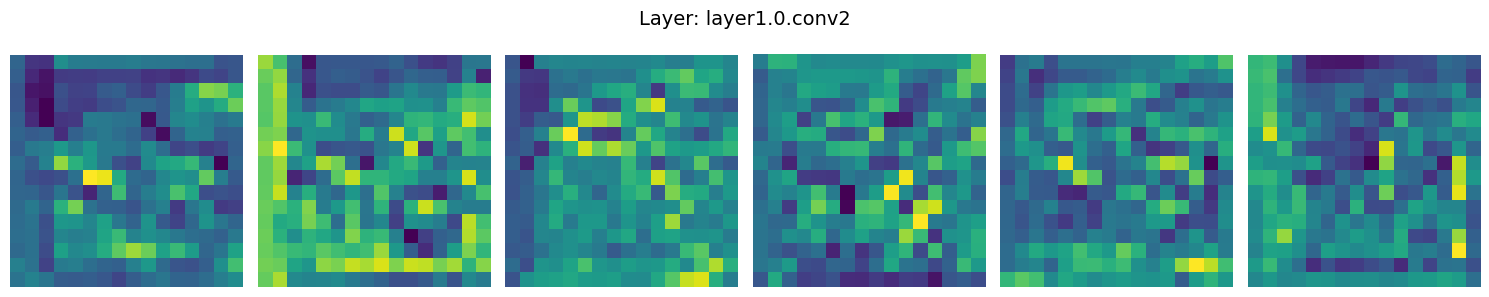

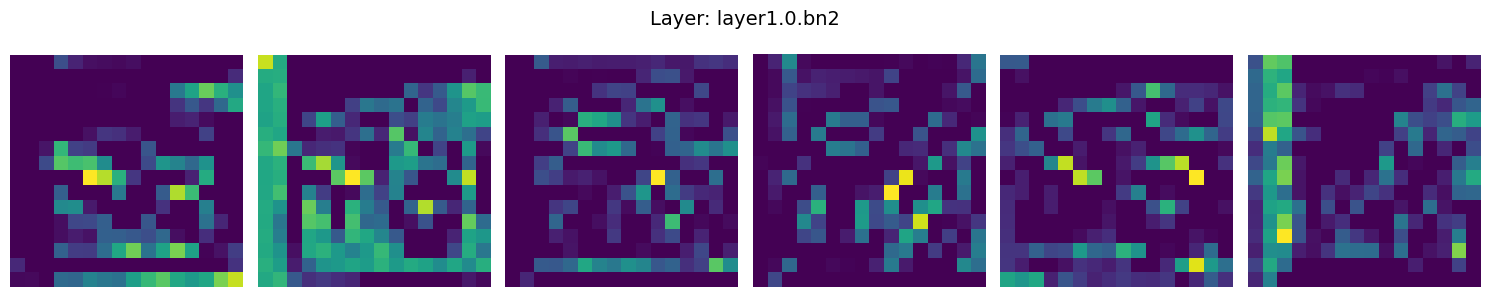

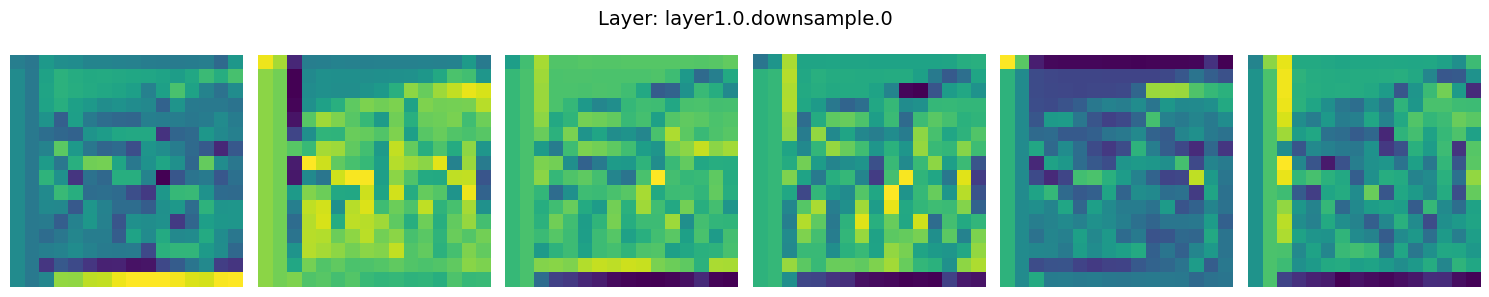

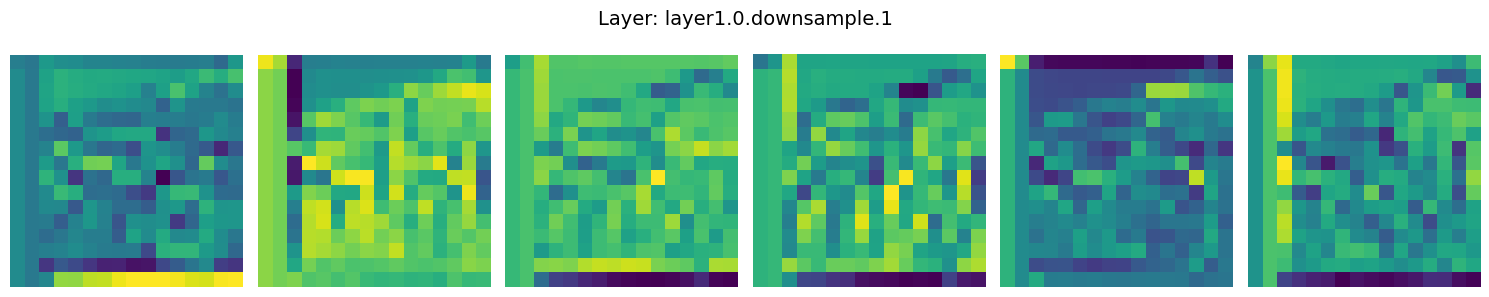

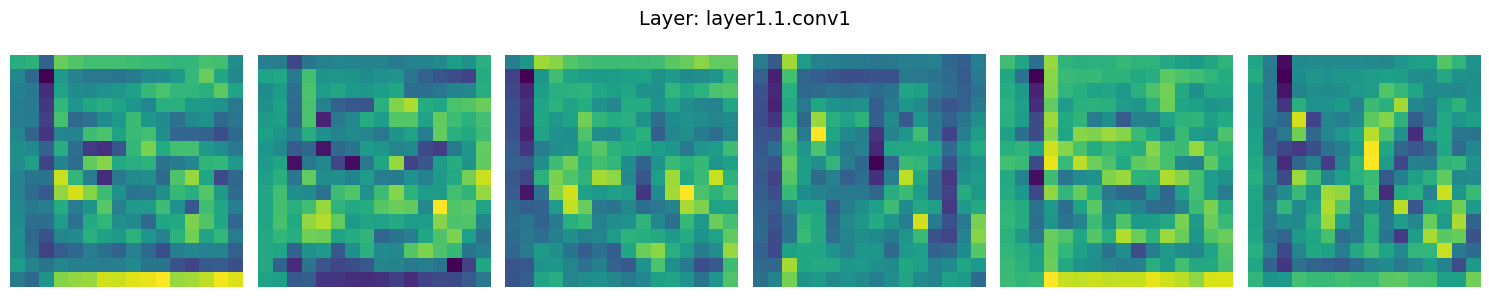

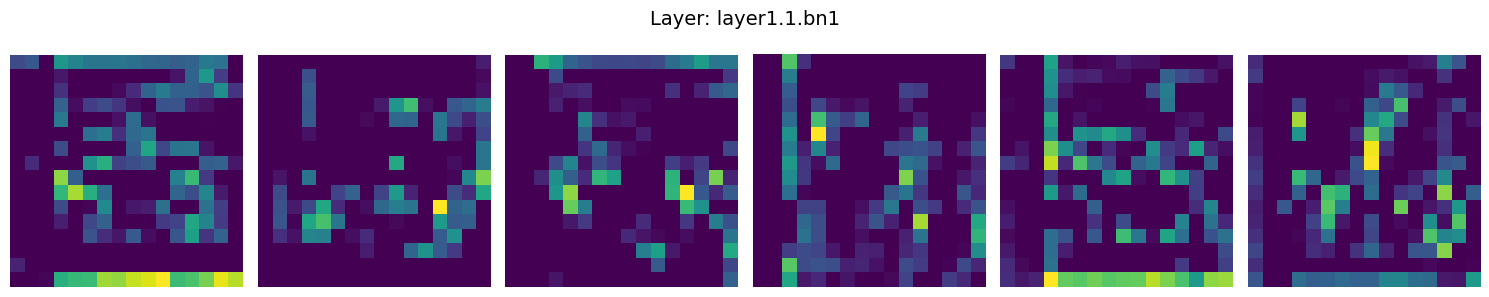

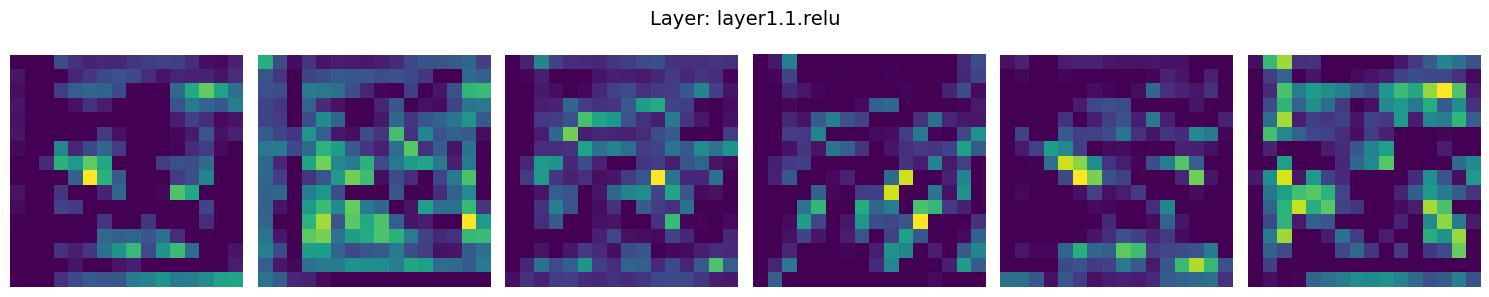

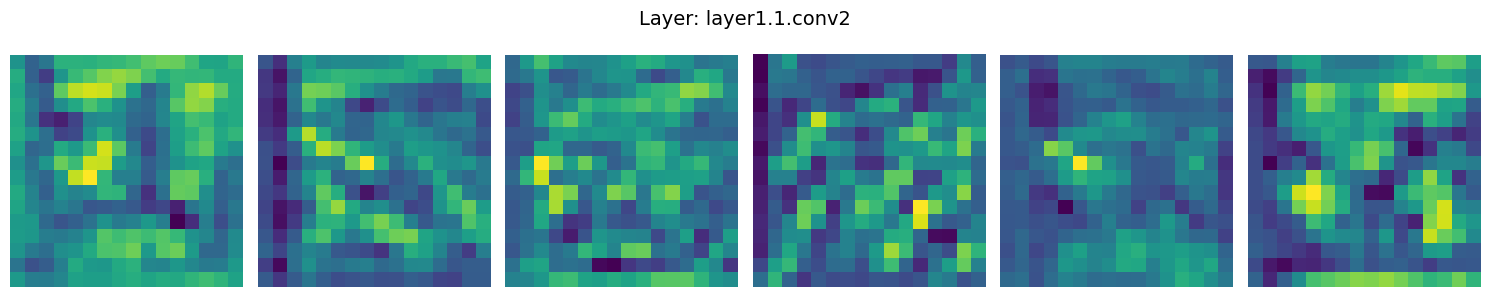

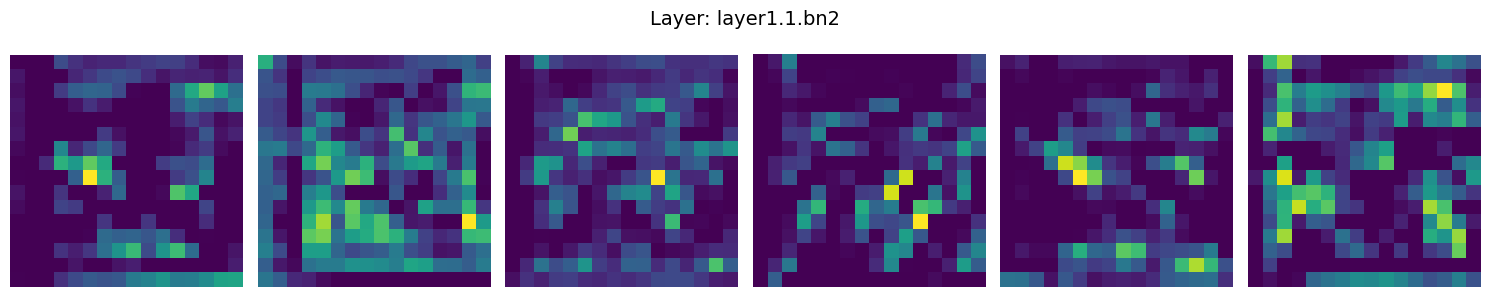

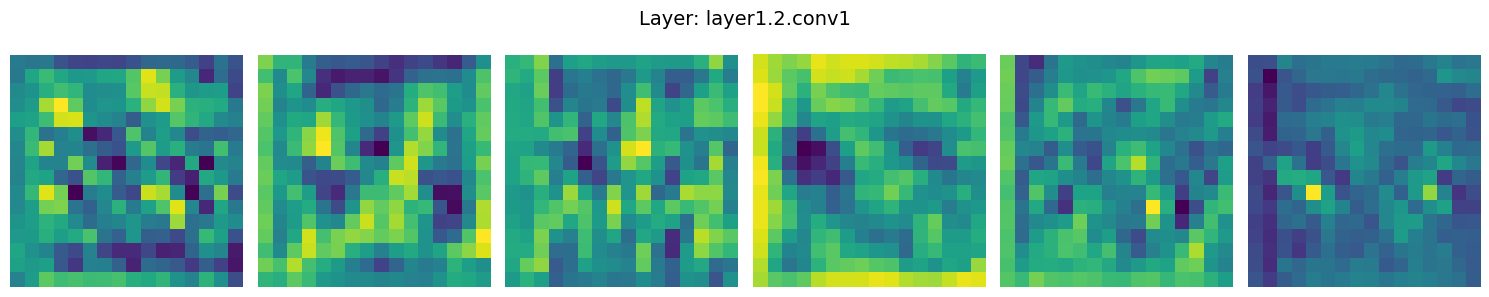

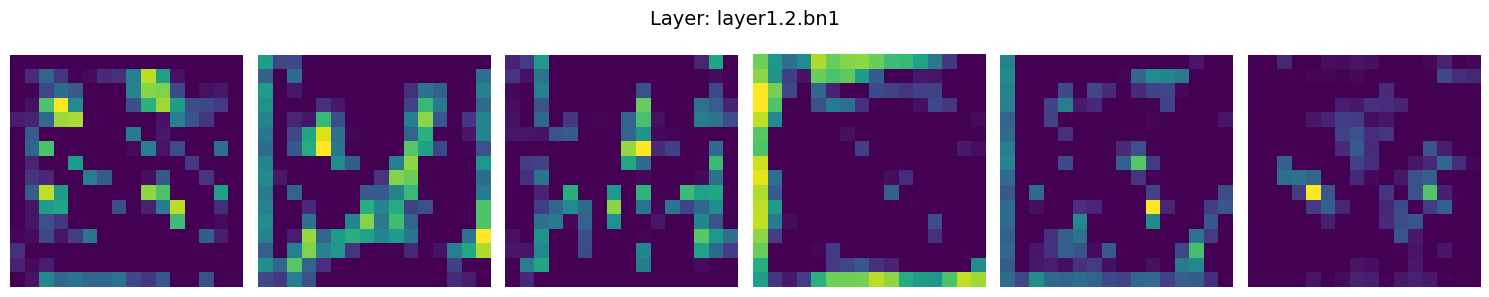

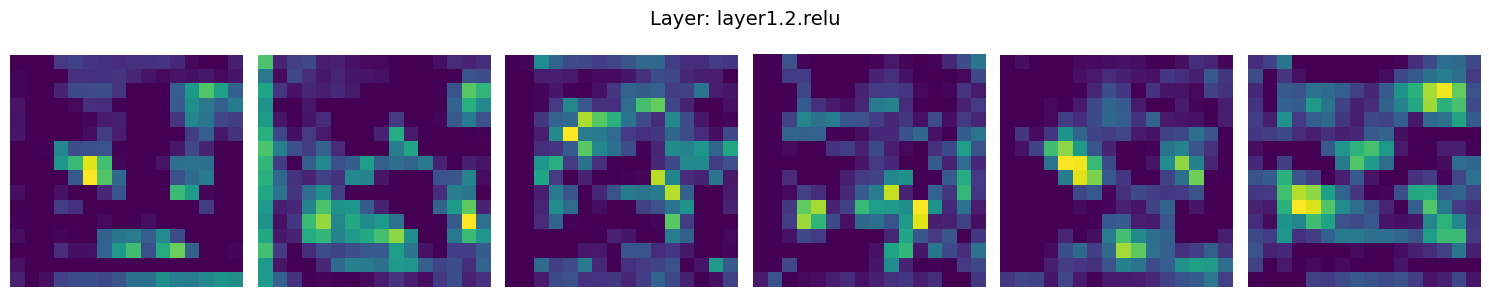

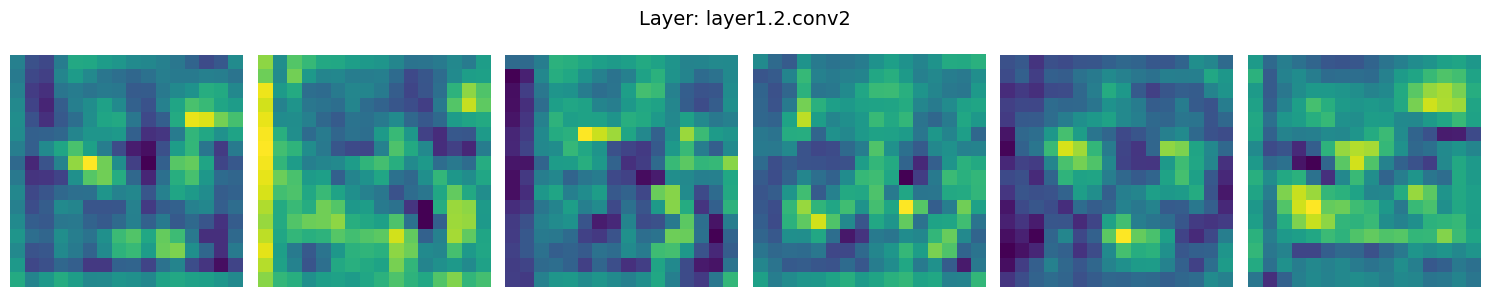

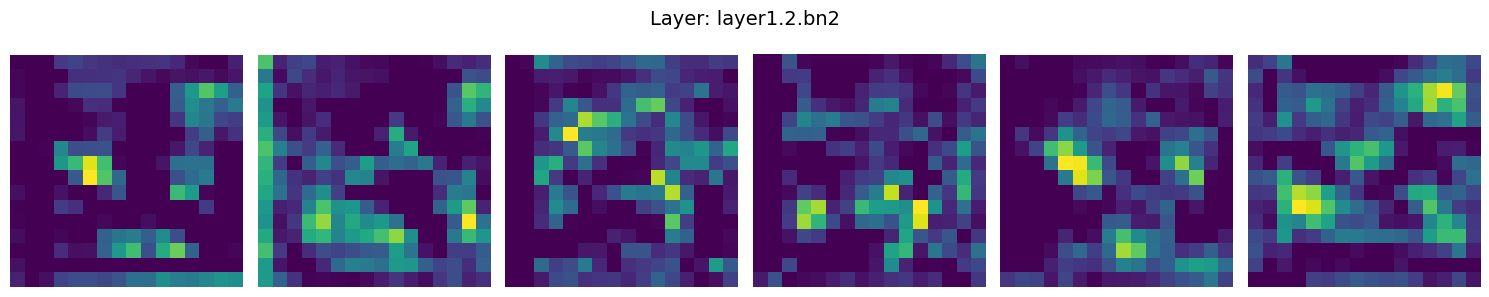

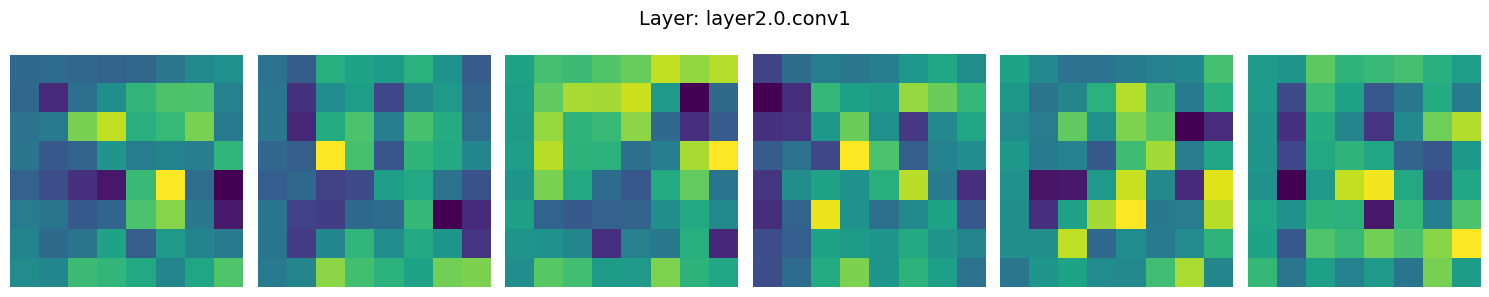

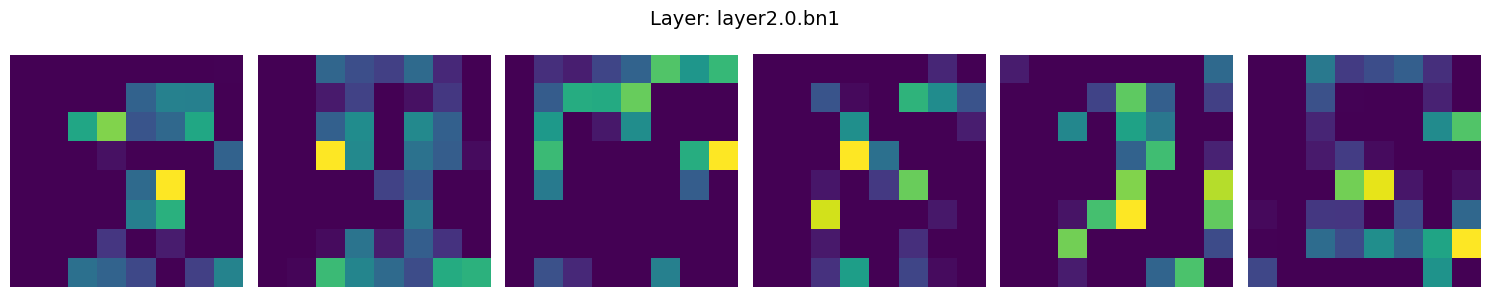

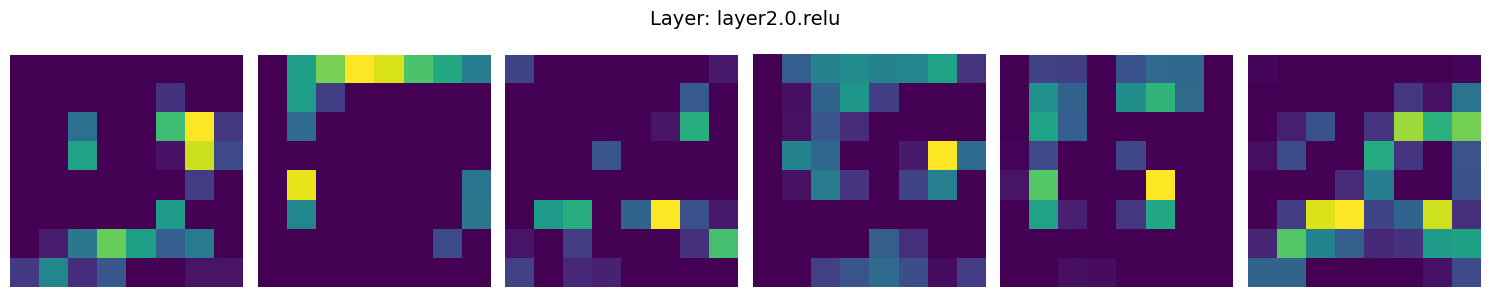

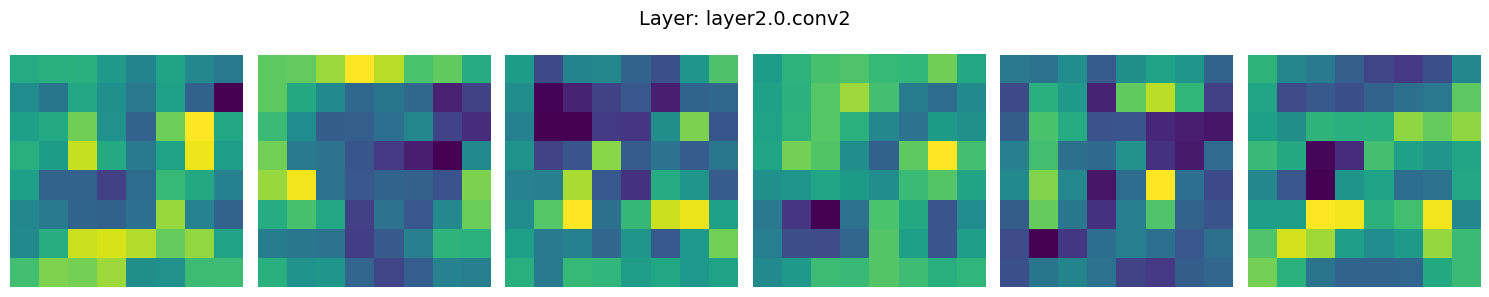

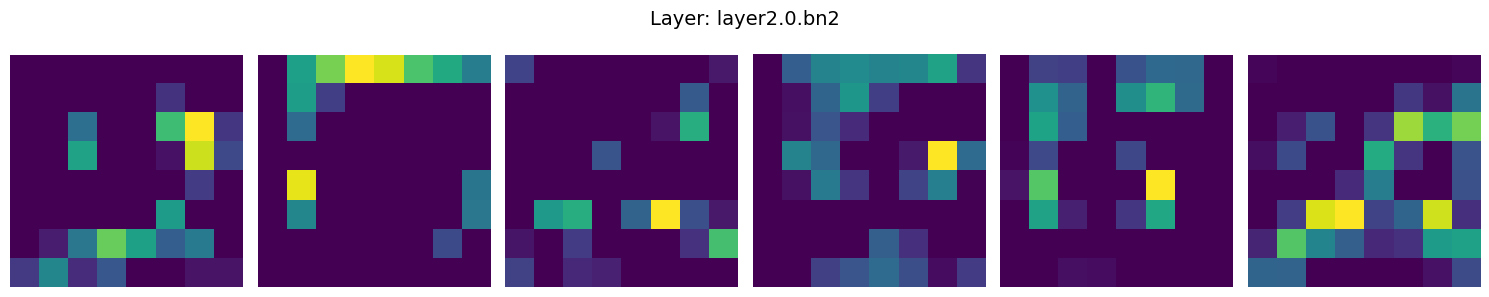

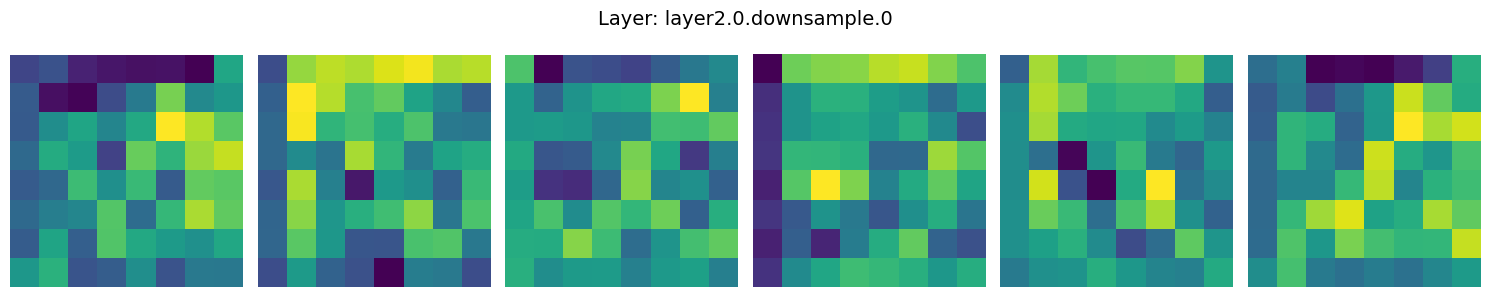

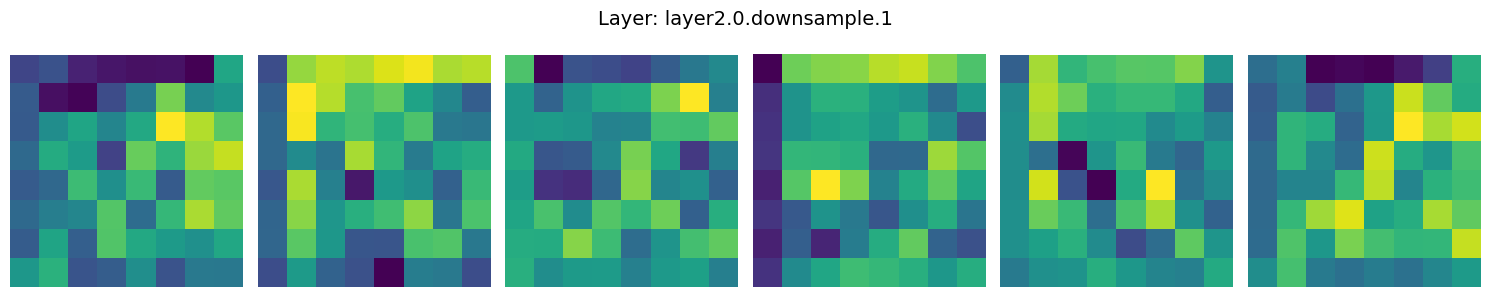

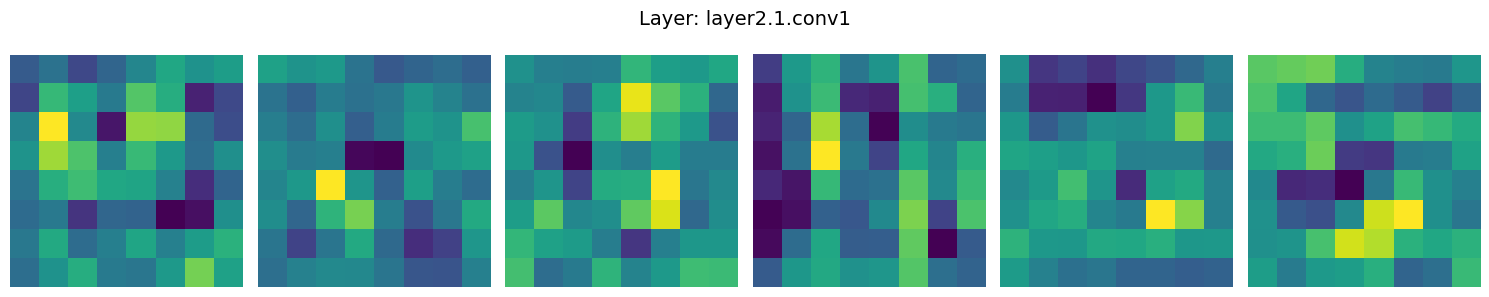

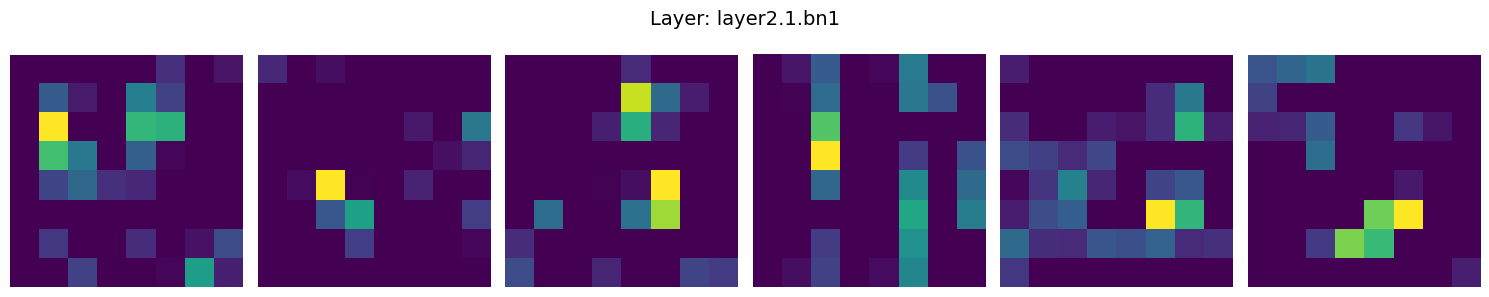

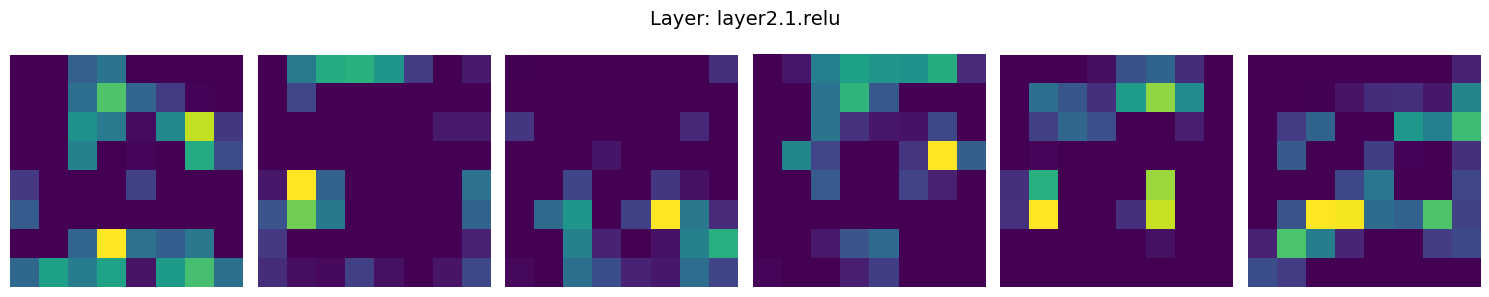

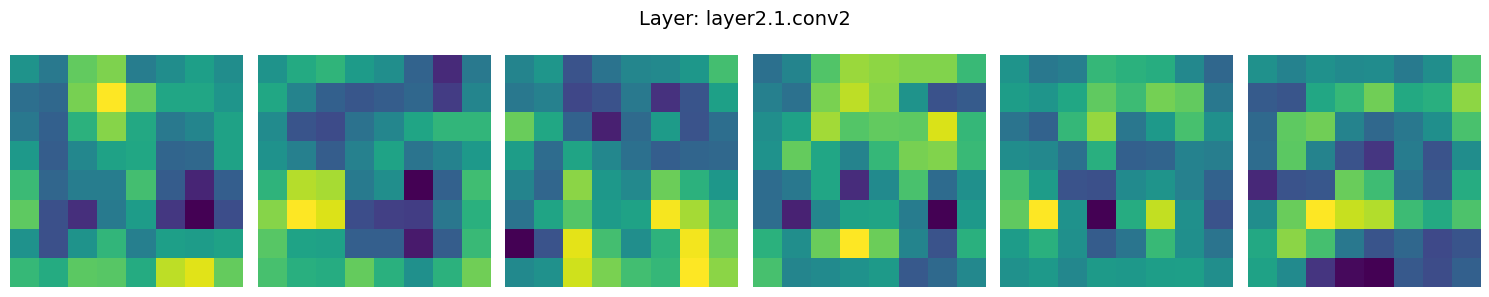

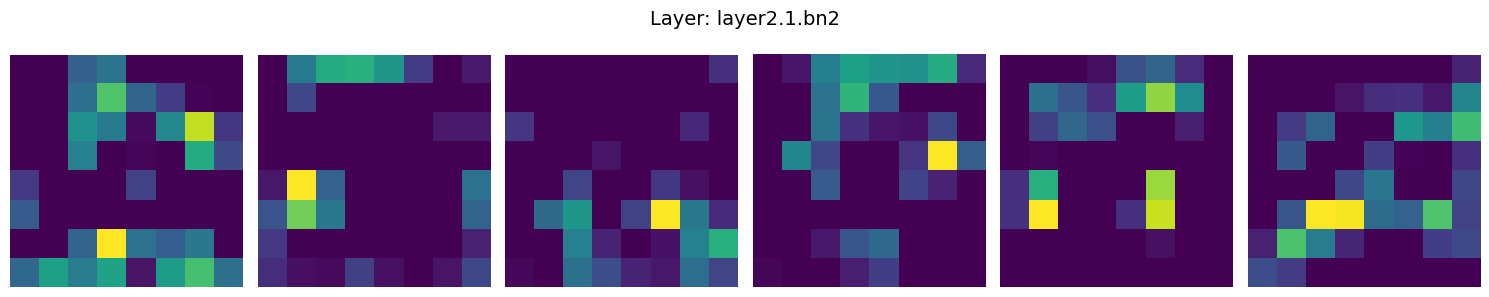

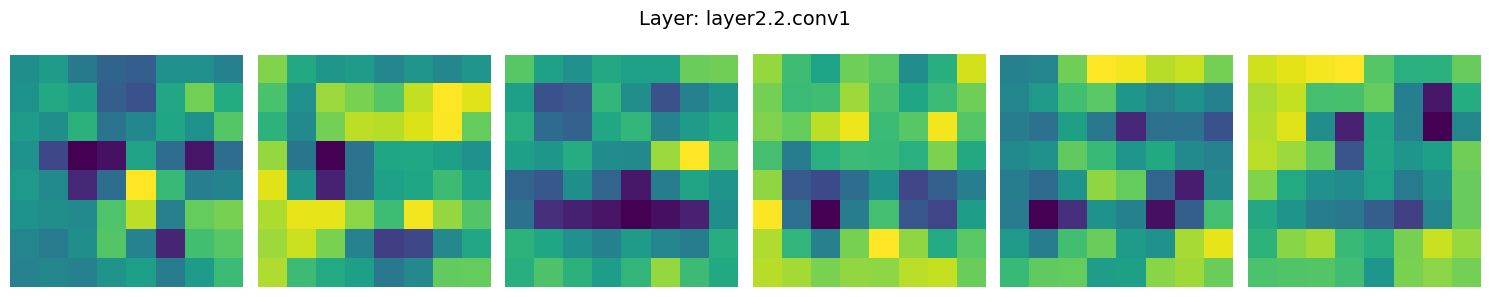

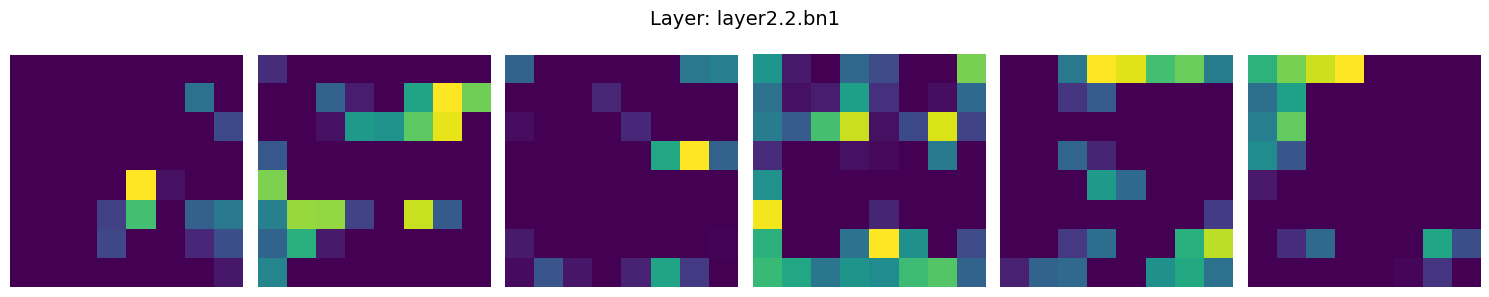

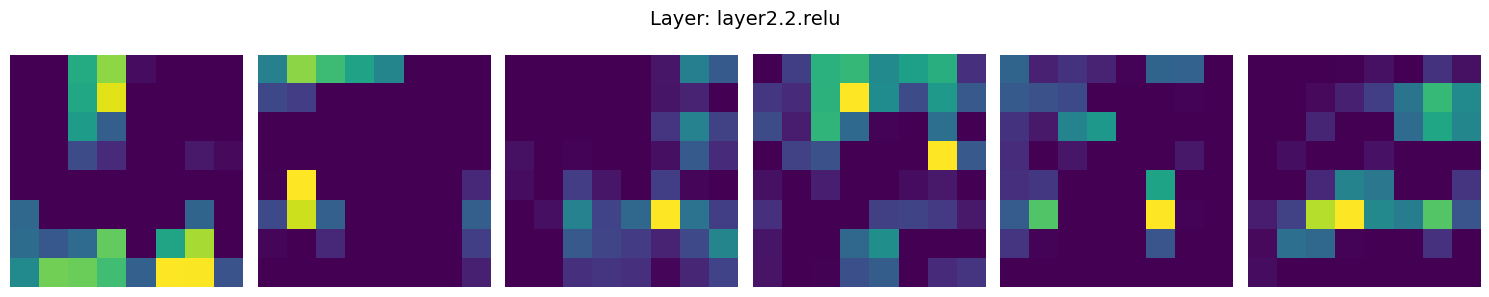

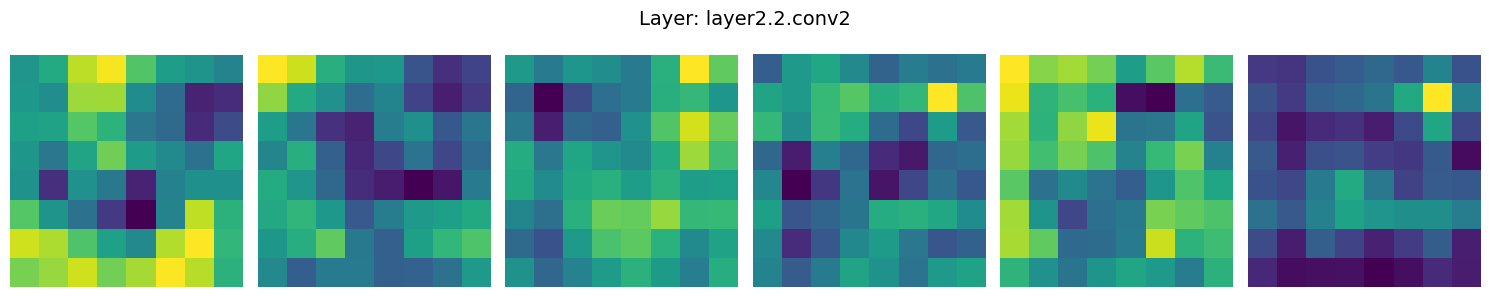

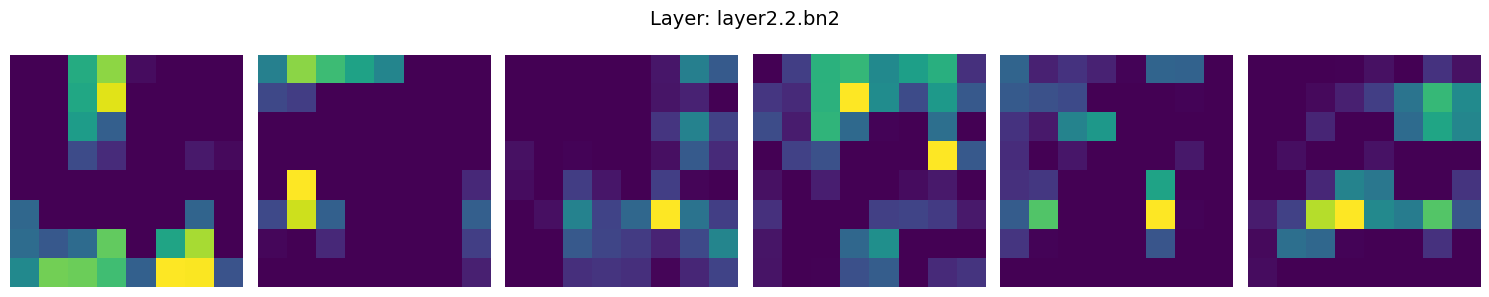

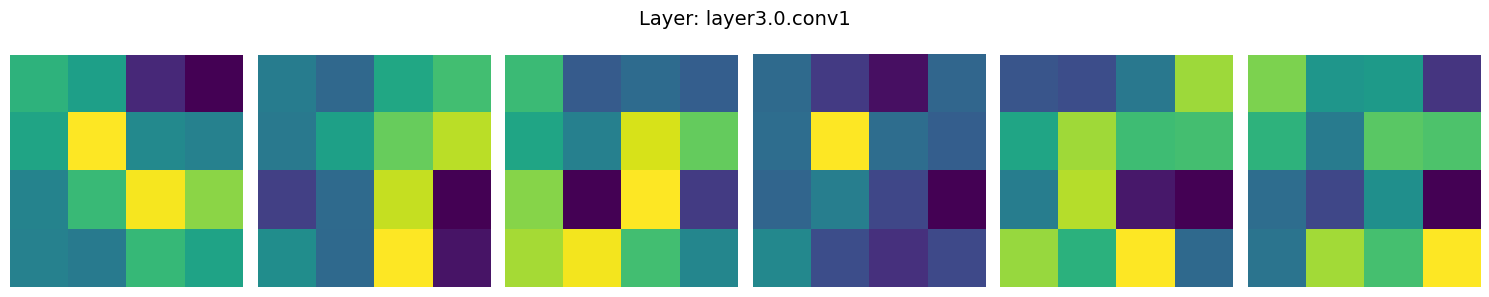

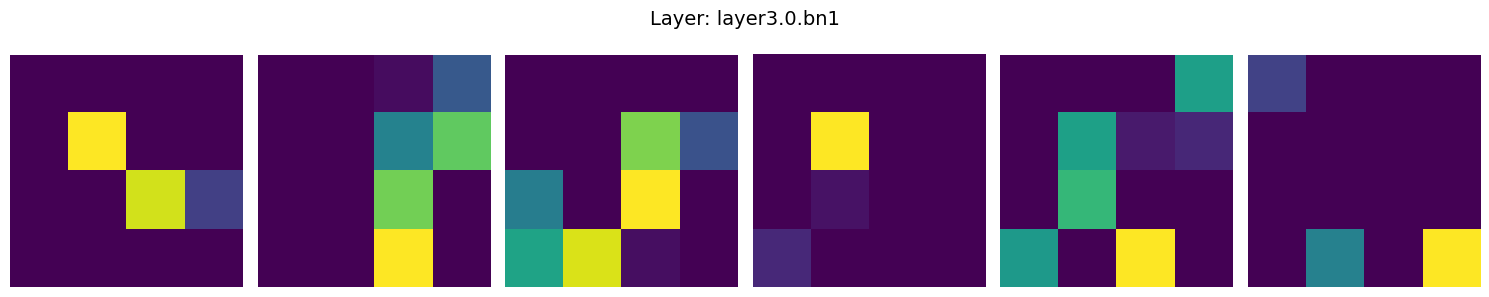

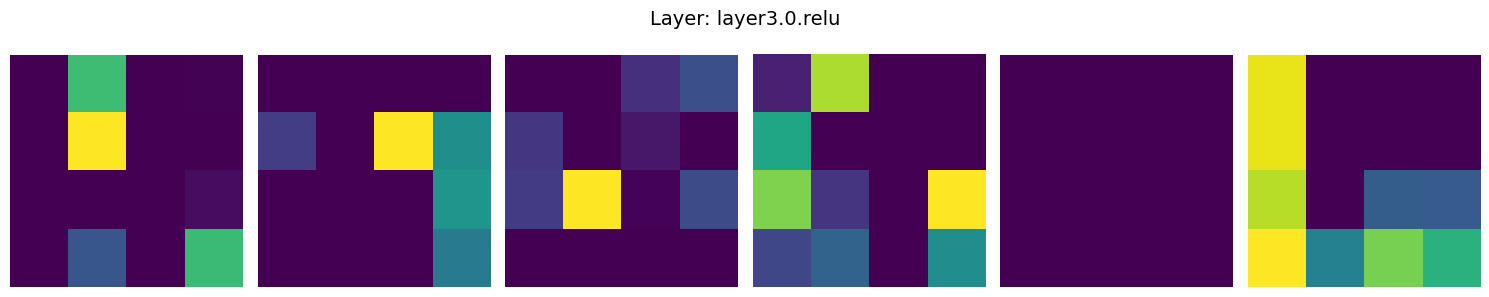

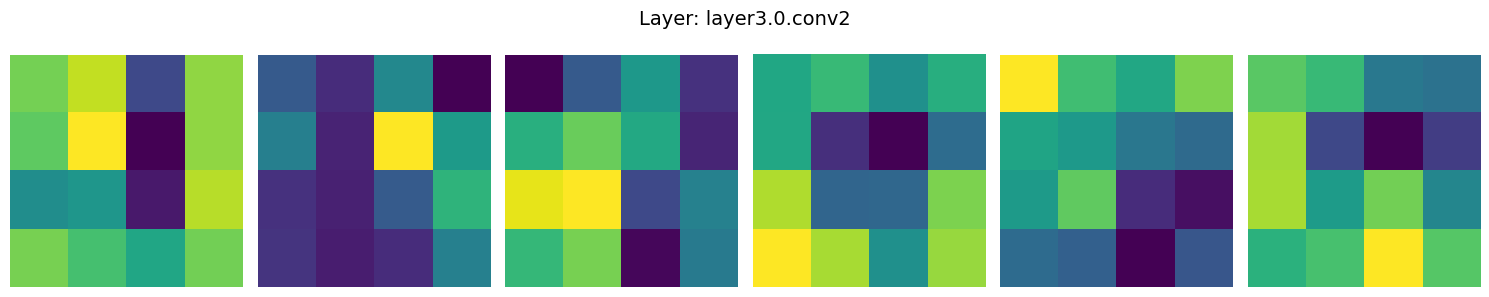

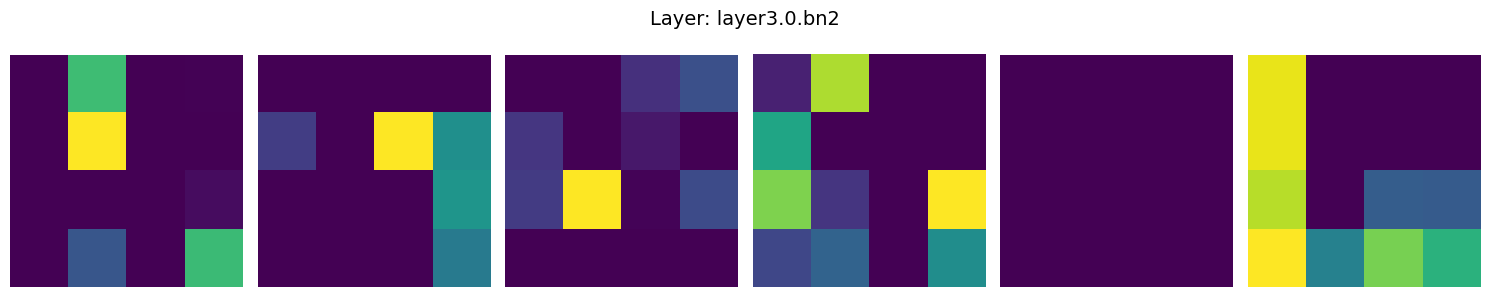

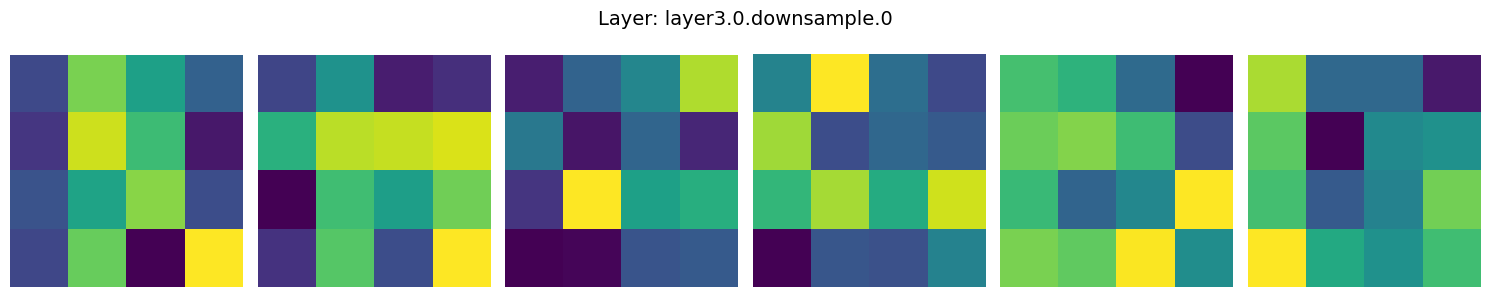

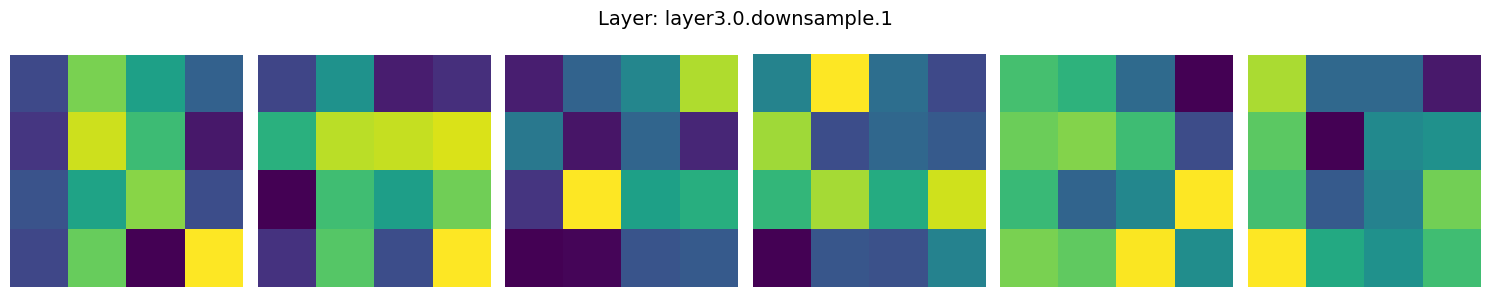

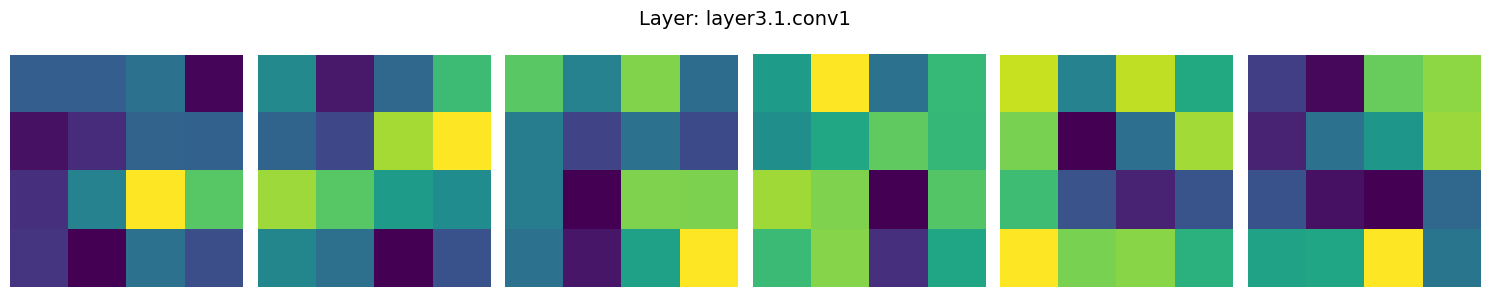

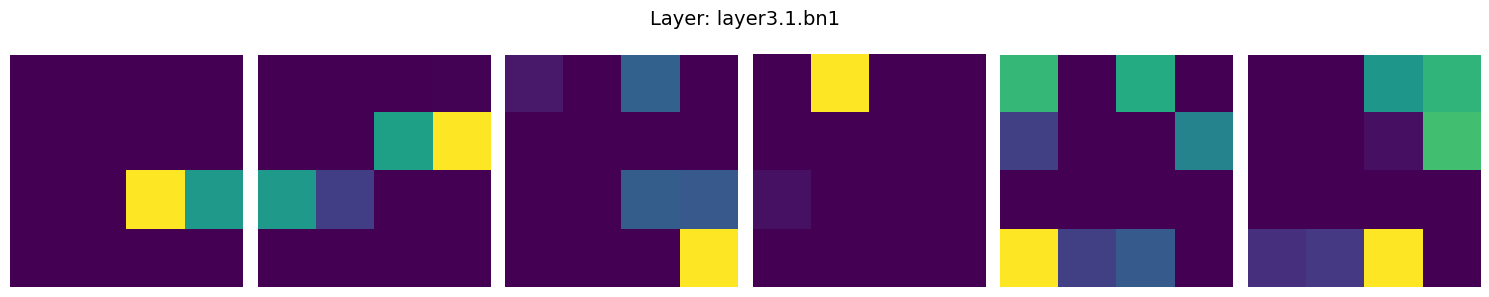

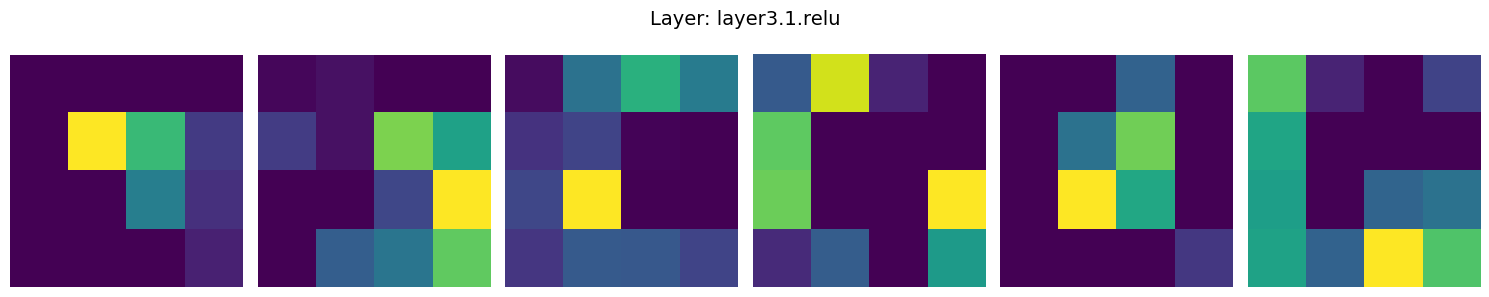

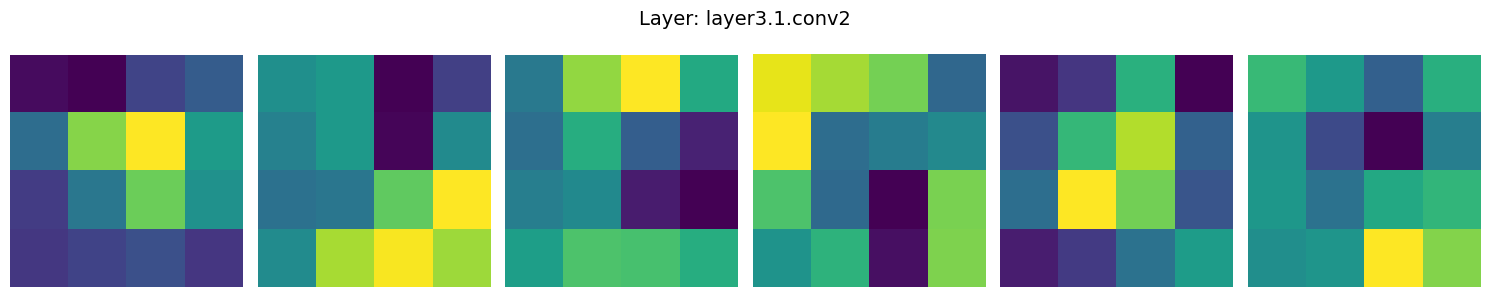

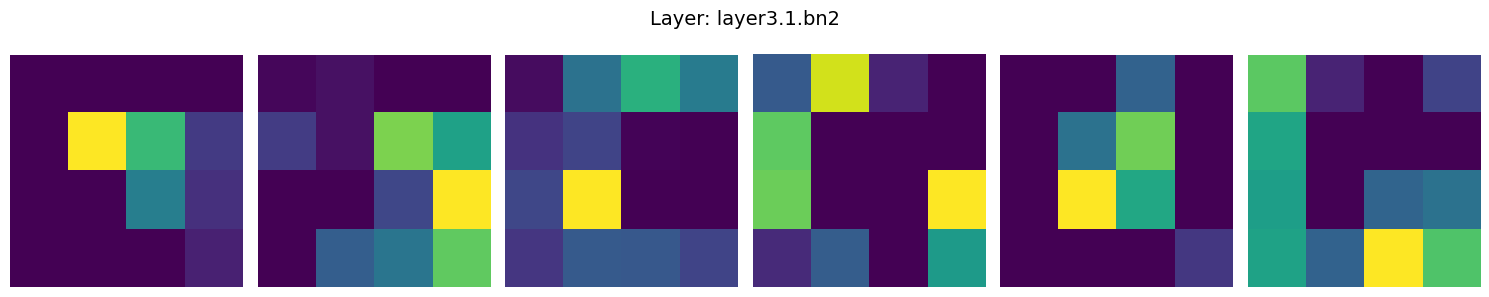

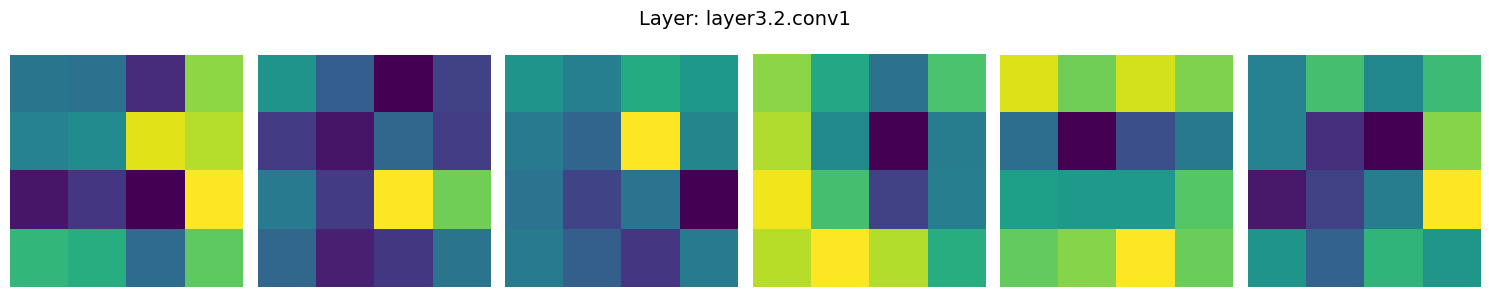

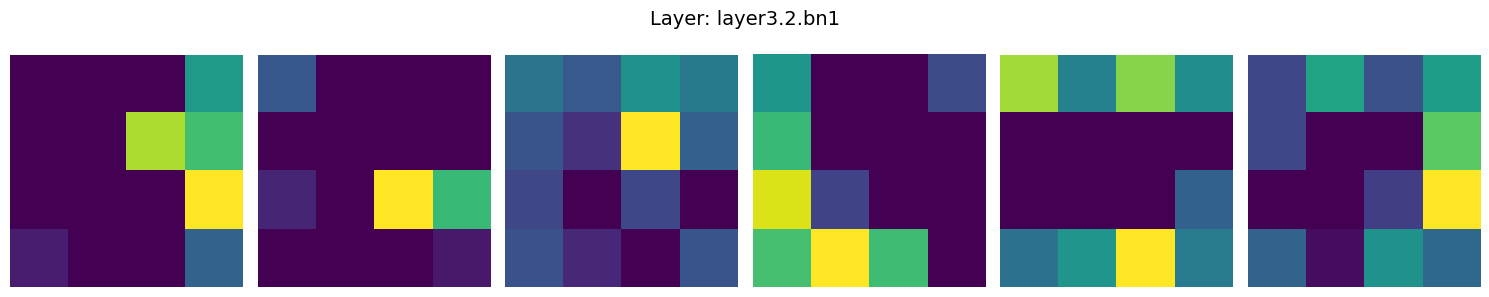

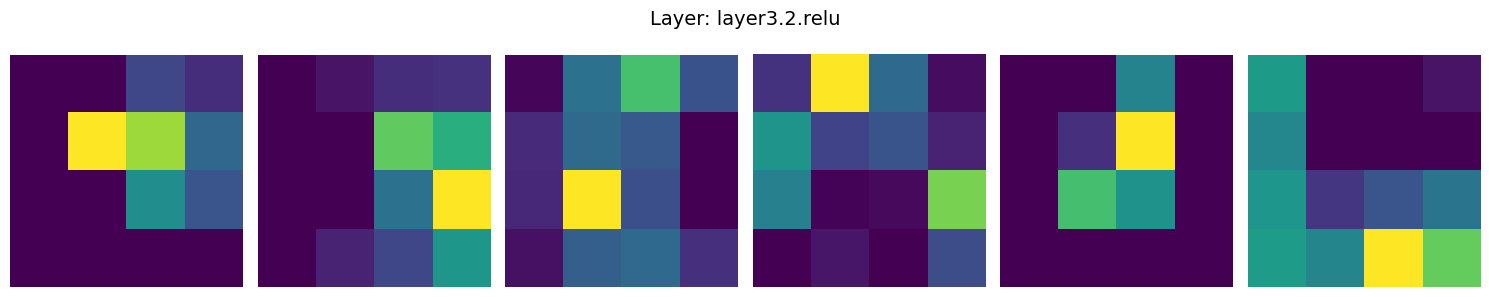

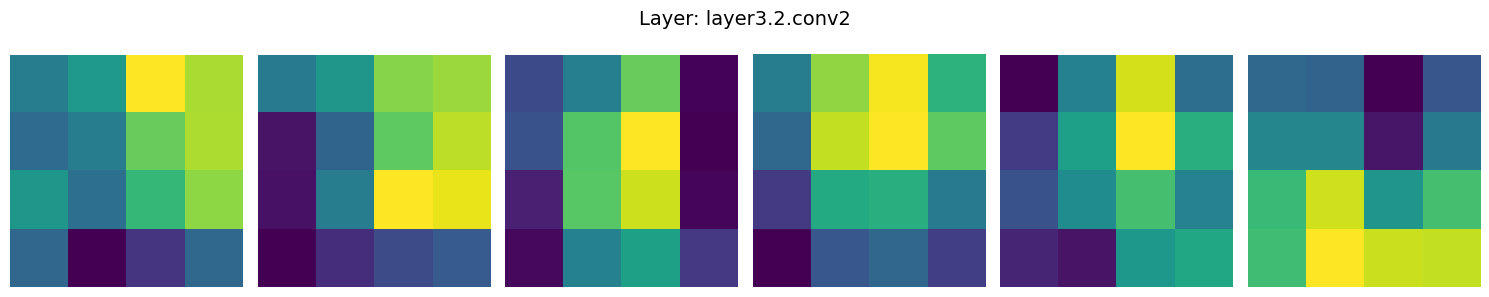

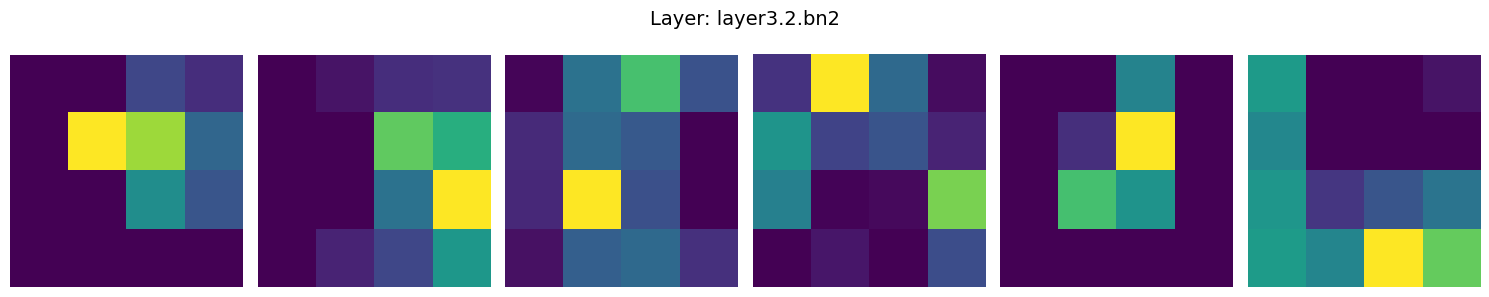

In [ ]:
from collections import OrderedDict
input_image = images  # shape: [1, 3, 32, 32]

feature_maps = OrderedDict()

def get_hook(name):
    def hook(module, input, output):
        feature_maps[name] = output.detach().cpu()
    return hook

for name, module in model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.BatchNorm2d)):
        module.register_forward_hook(get_hook(name))

with torch.no_grad():
    _ = model(input_image)


def plot_feature_maps(features_dict, max_channels=6):
    for layer_name, fmap in features_dict.items():
        n_channels = min(fmap.shape[1], max_channels)
        fig, axes = plt.subplots(1, n_channels, figsize=(15, 3))
        fig.suptitle(f"Layer: {layer_name}", fontsize=14)
        for i in range(n_channels):
            axes[i].imshow(fmap[0, i].numpy(), cmap='viridis')
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()

plot_feature_maps(feature_maps)

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import math

def visualize_all_feature_maps_in_one_figure(features_dict, max_channels=6):
    layers = list(features_dict.keys())
    num_layers = len(layers)
    cols = max_channels
    rows = num_layers

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    fig.suptitle("Feature Maps from All Layers", fontsize=16)

    for row_idx, layer_name in enumerate(layers):
        fmap = features_dict[layer_name][0]  # shape: [C, H, W]
        for col_idx in range(cols):
            ax = axes[row_idx, col_idx] if rows > 1 else axes[col_idx]
            if col_idx < fmap.shape[0]:
                ax.imshow(fmap[col_idx].numpy(), cmap='viridis')
                ax.set_title(f"{layer_name}\nch{col_idx}", fontsize=8)
            else:
                ax.axis('off')
            ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()